In [1]:
import numpy as np

## Class discussion 6 notes and solutions.

The topics covered here relate to the first part of the computational project, creating directly a policy using a function approximator. In the examples below the approximator is based on a linear function using a vector of features $\vec{x}$ and the corresponding weights $\theta$ which must be learned. The key difference between the different methods are in the way the weights are updated:

$$\theta \leftarrow \theta + \alpha \delta \nabla \ln \pi $$

here $\alpha$ is the usual step-size, and $\nabla \ln \pi$ is the gradient of the log policy function with respect to $\theta$. The only real difference between the methods is the way $\delta$ is chosen:

- REINFORCE: uses $\delta = G$ and $G$ is the return for the entire epsisode from that state (with discounting $\gamma$).
- REINFORCE using baseline: uses $\delta = G - \bar{G}$ where $\bar{G}$ is the state value function or baseline (mean returns from the state).
- Actor Critic: $\delta = r + V(s') - V(s)$, the usual TD-error, uses estimated values of subsequent states (bootstrapping).

I will start with using the two armed bandit problem below to illustrate the first two approaches and then use the short-corridor model to explain Actor-Critic. In both cases there are only two actions and only one state. In the bandit problem there is actually only one state, in the short-corridor model we assume we are using function approximation and so it appears that we only have one state for our policy approximation. I try to follow the pseudocodes in the book more directly to make the methods and differences between them clearer.

Other questions/answers are on the discussion page in Moodle.


### The Two Armed Bandit Problem solved using policy gradient methods

The bandit problem is discussed quite intensively in chapter 2, we will address these problems in more details in two weeks when covering exploration versus expoitation (XX). The problem here is that of trying to choose a "bandit" (spila-kassi) that returns on average the highest winnings. The winnings are modelled as a normal distribution, so the bandit with the highest mean is the one we are seeking, and when found we would like to play it forever.

Imagine a two armed bandit each returning on average values:

In [2]:
Rtrue = np.array([10,12])

We would like to learn to choose the arm with the highest reward with highest probability
### Policy iteration using function appoximation
Lets assume that the policy can be represented by the following function
$$
\pi (a) = \frac{\exp \big( \sum_{i=1}^2 \theta_i x_i(s,a) \big)}{\sum_{a = 0}^1\exp \big( \sum_{i=1}^2 \theta_ix_i(s,a) \big)}
$$
and let the features be
\begin{equation}
x_1(s,a) = x_1(a) = \begin{cases} 1 & \mbox{when } a = 0 \\
                       0 & \mbox{otherwise} \\
         \end{cases}
\end{equation}
and
$$
x_2(s,a) = x_2(a) = \begin{cases} 1 & \mbox{when } a = 1 \\
                       0 & \mbox{otherwise}
         \end{cases}
$$
Then 
$$
\pi (0) = \frac{\exp \big( \theta_1 \big)}{\exp(\theta_1)+\exp(\theta_2)}
$$
and
$$
\pi (1) = 1-\pi(0) = \frac{\exp \big( \theta_2 \big)}{\exp(\theta_1)+\exp(\theta_2)}
$$
Note that there is only one state $s$ and so we can drop it, i.e. $\pi(s,a)\equiv \pi(a)$. Futhermore, using these linear features makes this representation equivalent to a lookup table where $\theta_i$ will denote some *utility* value of action $i$ (not the expected returns!). Lets see how we might use the REINFORCE algorithm we start by computing gradients for the logarithm of the policy function:


In [3]:
import sympy as sp
th1, th2, x1, x2 = sp.symbols('Theta1 Theta2 X1 X1')
sp.init_printing()

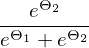

In [4]:
pi1 = sp.exp(th1) / ( sp.exp(th1) + sp.exp(th2) )
dpi1th1 = sp.simplify(sp.diff(sp.ln(pi1),th1))
dpi1th1

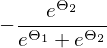

In [5]:
dpi1th2 = sp.simplify(sp.diff(sp.ln(pi1),th2))
dpi1th2

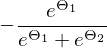

In [6]:
pi2 = sp.exp(th2) / ( sp.exp(th1) + sp.exp(th2) )
dpi2th1 = sp.simplify(sp.diff(sp.ln(pi2),th1))
dpi2th1

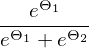

In [7]:
dpi2th2 = sp.simplify(sp.diff(sp.ln(pi2),th2))
dpi2th2

In other words the derivatives are:
$$
\frac{\partial \ln \pi(0|\theta)}{\partial \theta_1} = 1 - \pi(0)
$$
$$
\frac{\partial \ln \pi(0|\theta)}{\partial \theta_2} = -\pi(1)
$$
and
$$
\frac{\partial \ln \pi(1|\theta)}{\partial \theta_1}  = -\pi(0)
$$
$$
\frac{\partial \ln \pi(1|\theta)}{\partial \theta_2} = 1-\pi(1)
$$

In terms of our feature vector $x(s,a)\equiv x(a)$ we can write the above equations in a general matrix form:
$$
\nabla \ln \pi (a|\theta) = \vec{x}(a) - [\pi(0),\pi(1)] [\vec{x}(0),\vec{x}(1)]
$$
where $[\vec{x}(0),\vec{x}(1)]$ form a 2x2 matrix (identity matrix in this case) and $[\pi(0),\pi(1)]$ is a row vector (1x2). The  $\vec{x}(a)$ is a (2x1) column vector, when $a=0$ it is $[1,0]^T$ and when $a=1$ it is $[0,1]^T$. See also equation (13.9) in the book. Now we have everything to implement:
### REINFORCE

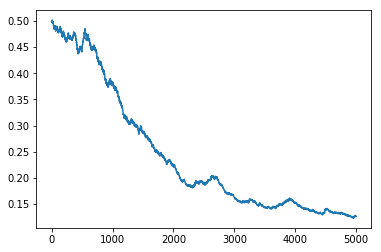

In [8]:
theta = np.ones(2) # equal value
alpha = .0005 # step size
gamma = 1 # so we ignore here
x = np.eye(2)
pi = lambda a, x, theta : np.exp(np.matmul(theta,x[:,a].T))/np.sum(np.exp(np.matmul(theta,x.T)))
life_of_pi = np.zeros( 5000 )
life_of_theta = np.zeros( (len(life_of_pi),2) )
for episode in range( len(life_of_pi) ):
    if np.random.uniform() < pi(0,x,theta):
        a = 0
    else:
        a = 1
    G = np.random.normal(loc = Rtrue[a]) # return of the bandit
    grad_ln_pi = x[:,a] - np.matmul(np.array( [pi(0,x,theta), pi(1,x,theta)] ), x)
    theta = theta + alpha * G * grad_ln_pi
    life_of_pi[episode] = pi(0,x,theta)
    life_of_theta[episode,:] = theta

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(life_of_pi)
plt.show()

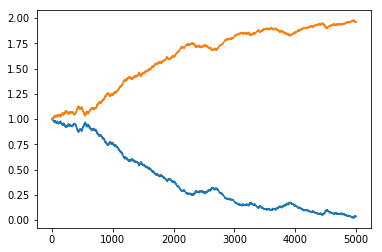

In [9]:
plt.plot(life_of_theta)
plt.show()

### REINFORCE with baseline:

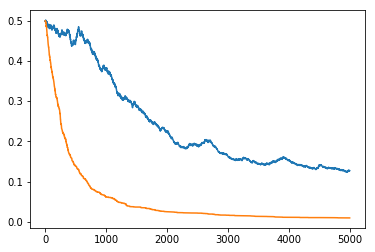

In [10]:
theta = np.ones(2) # equal value
alpha = .005 # step size
gamma = 1 # so we will ignore it here!
x = np.eye(2)
pi = lambda a, x, theta : np.exp(np.matmul(theta,x[:,a].T))/np.sum(np.exp(np.matmul(theta,x.T)))
life_of_pi_baseline = np.zeros( 5000 )
life_of_theta_baseline = np.zeros( (len(life_of_pi),2) )
Gmean = 0.0 # the mean return from state s and using policy pi
N = 0.0
for episode in range( len(life_of_pi_baseline) ):
    if np.random.uniform() < pi(0,x,theta):
        a = 0
    else:
        a = 1
    G = np.random.normal(loc=Rtrue[a]) # return of the bandit
    N += 1.0
    Gmean = Gmean + (1.0/N) * (G - Gmean) # incremental update of the mean
    nabla_pi = x[:,a] - np.matmul(np.array( [pi(0,x,theta), pi(1,x,theta)] ), x)
    theta = theta + alpha * (G - Gmean) * nabla_pi
    life_of_pi_baseline[episode] = pi(0,x,theta)
    life_of_theta_baseline[episode,:] = theta

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(life_of_pi)
plt.plot(life_of_pi_baseline)
plt.show()

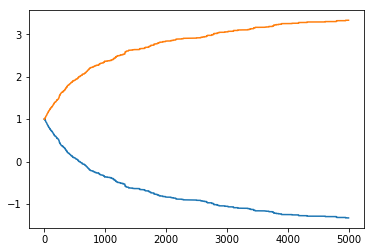

In [11]:
plt.plot(life_of_theta_baseline)
plt.show()

### Actor-Critic
We look now at the Actor Critic using a value function, for the $n$-armed bandit problem it will be equivalent to REINFORCE with baseline. To see the difference between the two methods we need to use bootstrapping (i.e. TD learning or estimating state value from estimated values of subsequent states). We need to look at a problem with more state than one, for this reason we will look at the *short corridor* problem. The value function for each state is put in a table (this is our critic), the policy (actor) is as above, as if we had only one state. We can re-use the policy def above, since we have only two actions here: go left and go right. 

In [12]:
def short_corridor_step(s,a):
    step = [-1,1]
    if s == 1:
        snew = s + step[1-a]
    else:
        snew = np.maximum(0,s + step[a]) # the states are (wall)0-1-2-3(terminal)
    if s == 3:
        r = 0 # terminal state
    else:
        r = -1
    return r, snew

$\pi(1) =$  0.5799802138175241
$V = $ [-11.6947947   -9.77393699  -4.04918091   0.        ]


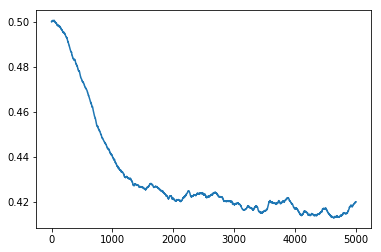

In [13]:
V = np.zeros(4) # value of the four states, note that V[3] = 0 by definition
theta = np.ones(2) # equal values to start off with
alpha_w = 0.01 # step sizes for values
alpha_th = 0.0001 # smaller step size for theta
gamma = 1 # so discounting is not used
x = np.eye(2)
pi = lambda a, x, theta : np.exp(np.matmul(theta,x[:,a].T))/np.sum(np.exp(np.matmul(theta,x.T)))
life_of_pi_ac = np.zeros( 5000 )
life_of_value_ac = np.zeros( (len(life_of_pi_ac)) )
for episode in range( len(life_of_pi_ac) ):
    s = 0 # initial state
    I = 1 # used for discounting
    while s < 3: 
        if np.random.uniform() < pi(0,x,theta):
            a = 0
        else:
            a = 1
        r, snew = short_corridor_step(s,a)
        delta = r + gamma*V[snew]-V[s]
        V[s] = V[s] + alpha_w*delta # note here we are just using a table directly so grad is 1
        grad_ln_pi = x[:,a] - np.matmul(np.array( [pi(0,x,theta), pi(1,x,theta)] ), x)
        theta = theta + alpha_th*I*delta*grad_ln_pi
        I = gamma*I
        s = snew
    life_of_pi_ac[episode] = pi(0,x,theta)
    life_of_value_ac[episode] = V[0]

%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(life_of_pi_ac)
print("$\pi(1) =$ ", pi(1,x,theta))
print("$V = $", V)

The value of state $S$ in example, 13.1. See also figures 13.1 and 13.2 in the book, these figures show the REINFORCE and REINFORCE with baseline algorithms performance. The code supplied by the book are a little non-transparent, and a little bit more complicated than what I have supplied above (they seem to add $\epsilon=0.05$ greedy style exploration, since the agent tends to get stuck by the wall, this was not needed for the Actor-Critic). Learning a noisy policy means that we should not need to explicitly force exploration, or what? Notice also the fluctuation as we reach the optimal, clearly in this region the step size $\alpha$ is too large.

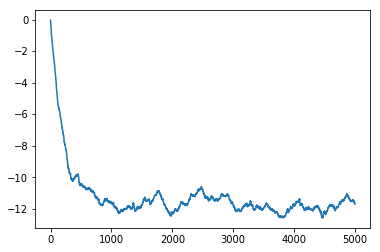

In [14]:
plt.plot(life_of_value_ac)
plt.show()

### The symbolic expression for this problem
From the Bellman equation (first weeks or study) we have the following for the short corridor problem (see also exercise 13.1):
$$V_s = \pi(V_b-1)+(1-\pi)(V_s-1)$$
$$V_b = \pi(V_s-1)+(1-\pi)(V_c-1)$$
$$V_c = \pi(-1) + (1-\pi)(V_b-1)$$

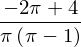

In [15]:
# we can solve this using sympy:
Vs, Vb, Vc, pi = sp.symbols('Vs Vb Vc pi')
expr = sp.solve([-Vs+pi*(Vb-1)+(1-pi)*(Vs-1),-Vb+pi*(Vs-1)+(1-pi)*(Vc-1),-Vc+pi*(-1)+(1-pi)*(Vb-1)],(Vs,Vb,Vc))
expr[Vs]

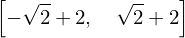

In [16]:
optimal_pi = sp.solve((sp.diff(expr[Vs],pi)))
optimal_pi

The optimal policy if therefore $\pi^* = 2-\sqrt{2}$ since the probability cannot be greater than 1.

In [17]:
optimal_pi = -np.sqrt(2)+2
optimal_pi

In [18]:
optimal_Vs = expr[Vs].subs(pi,optimal_pi)
optimal_Vs